<a href="https://colab.research.google.com/github/comparativechrono/ChronomicMedicine/blob/main/GWAS_query_multiple_samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Querying GWAS catalogue with multiple samples

## Step 1. Data retrieval and pre-processing

Obtain GWAS catalogue data from EBI

In [1]:
! wget -O gwas.txt https://www.ebi.ac.uk/gwas/api/search/downloads/alternative

--2023-02-23 21:30:22--  https://www.ebi.ac.uk/gwas/api/search/downloads/alternative
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/tsv]
Saving to: ‘gwas.txt’

gwas.txt                [       <=>          ] 293.92M  7.97MB/s    in 57s     

2023-02-23 21:31:19 (5.15 MB/s) - ‘gwas.txt’ saved [308199696]



In [2]:
! head gwas.txt

DATE ADDED TO CATALOG	PUBMEDID	FIRST AUTHOR	DATE	JOURNAL	LINK	STUDY	DISEASE/TRAIT	INITIAL SAMPLE SIZE	REPLICATION SAMPLE SIZE	REGION	CHR_ID	CHR_POS	REPORTED GENE(S)	MAPPED_GENE	UPSTREAM_GENE_ID	DOWNSTREAM_GENE_ID	SNP_GENE_IDS	UPSTREAM_GENE_DISTANCE	DOWNSTREAM_GENE_DISTANCE	STRONGEST SNP-RISK ALLELE	SNPS	MERGED	SNP_ID_CURRENT	CONTEXT	INTERGENIC	RISK ALLELE FREQUENCY	P-VALUE	PVALUE_MLOG	P-VALUE (TEXT)	OR or BETA	95% CI (TEXT)	PLATFORM [SNPS PASSING QC]	CNV	MAPPED_TRAIT	MAPPED_TRAIT_URI	STUDY ACCESSION	GENOTYPING TECHNOLOGY
2017-08-22	28448500	Graff M	2017-04-27	PLoS Genet	www.ncbi.nlm.nih.gov/pubmed/28448500	Genome-wide physical activity interactions in adiposity - A meta-analysis of 200,452 adults.	Waist-to-hip ratio adjusted for BMI in active individuals	1,957 African American women, 1,421 Filipino ancestry women, 305 Indian ancestry women, 65,539 European ancestry women, 1,206 African American men, 2,029 Indian ancestry men, 41,673 European ancestry men, 4,819 European ancestry indivi

## Perform analysis in R

Set-up R environment

In [3]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rpy2-3.5.1-cp38-cp38-linux_x86_64.whl


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)


✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [6]:
%%R
gwas <- read_tsv("gwas.txt")

Rows: 487213 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (27): FIRST AUTHOR, JOURNAL, LINK, STUDY, DISEASE/TRAIT, INITIAL SAMPLE...
dbl   (9): PUBMEDID, UPSTREAM_GENE_DISTANCE, DOWNSTREAM_GENE_DISTANCE, MERGE...
date  (2): DATE ADDED TO CATALOG, DATE

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
%%R
summary(gwas)

 DATE ADDED TO CATALOG    PUBMEDID        FIRST AUTHOR      
 Min.   :2008-06-10    Min.   :15761122   Length:487213     
 1st Qu.:2019-02-21    1st Qu.:30289880   Class :character  
 Median :2021-02-03    Median :32888494   Mode  :character  
 Mean   :2020-07-09    Mean   :32168327                     
 3rd Qu.:2022-04-27    3rd Qu.:34610981                     
 Max.   :2023-02-09    Max.   :36658081                     
                                                            
      DATE              JOURNAL              LINK              STUDY          
 Min.   :2005-03-10   Length:487213      Length:487213      Length:487213     
 1st Qu.:2018-10-03   Class :character   Class :character   Class :character  
 Median :2020-09-01   Mode  :character   Mode  :character   Mode  :character  
 Mean   :2019-12-29                                                           
 3rd Qu.:2021-09-30                                                           
 Max.   :2023-01-19                   

Remove Jones et al study from GWAS data frame

In [26]:
%%R
# code to drop 
gwas <- gwas %>% filter(PUBMEDID != 30696823)

import chronotype IDs

In [36]:
%%R
# Create example query data frame
query_df <- read_tsv("GWAS_chronotype_rsIDs.txt", col_names = FALSE, skip = 0)

Rows: 351 Columns: 1
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [37]:
%R query_df

,X1
1,rs909757
2,rs61773390
3,rs12065331
4,rs17448682
5,rs10917513
...,...
347,rs9611597
348,rs6007594
349,rs3747463
350,rs213462


In [38]:
%%R
library(dplyr)
library(stringr)


# Filter tibble based on whether it contains any of the rows in query data frame
filtered_tibble <- gwas %>%
  filter(sapply(str_extract_all(SNPS, "[a-zA-Z0-9]+"), 
                function(x) any(x %in% query_df$X1)))

# Print filtered tibble
# print(filtered_tibble)


Search through gwas catalogue and pull out variant

In [27]:
%%R
library(dplyr)
library(stringr)

# Create example query data frame
query_df <- "rs909757"

# Filter tibble based on whether it contains any of the rows in query data frame
filtered_tibble <- gwas %>%
  filter(sapply(str_extract_all(SNPS, "[a-zA-Z0-9]+"), 
                function(x) any(x %in% query_df)))

# Print filtered tibble
# print(filtered_tibble)


In [39]:
%%R
filtered_tibble$PUBMEDID


  [1] 29029846 29899525 26961502 30617275 30595370 30595370 30679032 30239722
  [9] 30679032 30679032 30275891 30679032 30679032 30510241 29403010 30239722
 [17] 30487518 30595370 31453325 31453325 31453325 31453325 31453325 31453325
 [25] 30643258 31519223 31326317 30593698 30593698 30593698 30593698 30593698
 [33] 30593698 31263887 30595370 30072576 32393786 31097437 30643258 30593698
 [41] 30643258 30593698 29381148 32332799 30573740 32317632 33402679 33402679
 [49] 32317632 31840077 30072576 32157176 32157176 33075057 33075057 32352494
 [57] 32352494 33082346 31740837 31900758 30595370 32889700 32889700 27089181
 [65] 27992416 27992416 27992416 27992416 27488534 27494321 27494321 27494321
 [73] 27494321 26634245 26835600 26835600 26835600 26835600 26604143 26634245
 [81] 21873549 27863252 25201988 24952745 25006744 25006744 24189344 23563607
 [89] 17634447 19151714 19151714 19151714 23704328 23563609 23636237 23251661
 [97] 32066663 32154731 30297969 30239722 30239722 30595370 3029

In [57]:
%%R
table(filtered_tibble$PUBMEDID)
df <- table(filtered_tibble$`DISEASE/TRAIT`)

In [58]:
%%R 
df <- as.data.frame(df)

In [59]:
%%R
colnames(df)

[1] "Var1" "Freq"


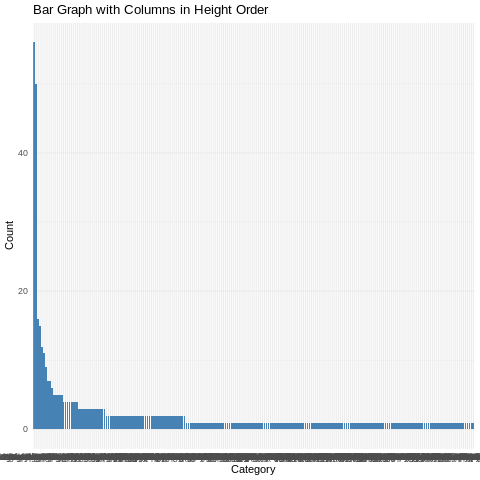

In [54]:
%%R
library(ggplot2)

# Sort data frame in descending order by count
df <- df[order(-df$Freq),]

# Create bar graph with columns in height order
ggplot(df, aes(x = reorder(Var1, -Freq), y = Freq)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Bar Graph with Columns in Height Order", x = "Category", y = "Count") +
  theme_minimal()


In [ ]:
%like%

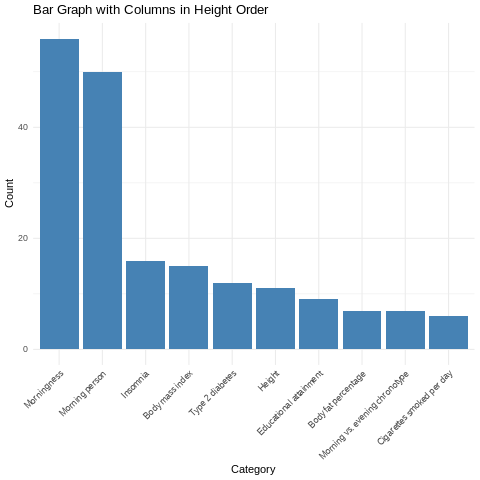

In [61]:
%%R
library(ggplot2)

df <- df %>% filter(Freq > 5)

# Sort data frame in descending order by count
df <- df[order(-df$Freq),]

# Create bar graph with columns in height order
ggplot(df, aes(x = reorder(Var1, -Freq), y = Freq)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(title = "Bar Graph with Columns in Height Order", x = "Category", y = "Count") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
